### Tarefa 5 - Implementar um identificador de citações
- Objetivo:
    - "...ter um identificador de citações que retorna uma uma lista das citações para uma determinada resolução, e que retorna uma lista contendo id_resolucao e id_resolucao_citante;"
- https://taiga.anatel.gov.br/project/tpbvieira-resolucoes/us/5?kanban-status=51

Fontes:
- https://spacy.io/usage/processing-pipelines
- https://spacy.io/api/language

In [1]:
import pandas as pd
import re

# https://spacy.io/
import spacy
from spacy.matcher import Matcher

# As funcionalidades NER e TextCat foram desabilitadas para que ocupe menos memória RAM
# e para que o pipeline do spaCy fique mais rápido.
# nlp é o nome dado ao objeto do tipo pipeline do spaCy e
# foi carregado o modelo de linguagem para português tamanho small - pt_core_news_sm
nlp = spacy.load('pt_core_news_sm', disable=['ner','textcat'])

# Aumenta o limite de leitura (quantidade de caracteres) para cada documento.
# max_length deve ser redimensionado conforme for a situação e necessidade.
nlp.max_length = 1500000 

### Prepara para leitura do `corpus` de Resoluções da Anatel  
- Para o programa citacoes.ipynb funcionar, atualmente, são necessários os arquivos:
	- resolucoes_text.csv
	- nro_id_resolucao.csv
- `Corpus` resolucoes_text.csv
- `Lista` com id e nro de cada Resolução: nro_id_resolucao.csv  
- Baixo código SQL que gera a lista  
    select  

        distinct substring(alias, length(substring_index(alias, '-', 1))+2, length(alias)) as nro_res, 

        ctx.id, ctx.alias, ctx.title  

    from prod_legislacao.bno4z_content ctx  

    where   

            lower(ctx.title) like 'resolu%'  

        and ctx.language <> 'en-US'   

        and ctx.language <> 'es-ES'   

        and state=1  

    order by nro_res  
    

In [2]:
arq = "resolucoes_text.csv" # corpus
arq_nro_res = "nro_id_resolucao.csv" # lista
# dir = "/home/marcello/git/anatel/datasets/" 
dir = "C:/Users/sandi.engesoftware/Documents/workspace/resolucoes-similaridade/datasets/"
sep = "|" 
enc = "utf-8"
# dataframe com o par id e texto das Resoluções
resolucoes = pd.read_csv(dir+arq, sep=sep, encoding=enc)
# dataframe com a lista das Resoluções e seus respectivos nro e id
nro_id_resolucao = pd.read_csv(dir+arq_nro_res, sep=',', encoding=enc)

### Identificação dos padrões de citações
- No momento foram identificados nove tipos de padrões de escrita das Citações.
- Os padrões são preparados para estarem no formato de dicionário chave:valor.
- Matcher (https://spacy.io/api/matcher) é uma classe do spaCy preparada para identificar em seu pipeline os tokens estruturados contidos no dicionário de padrões pré-construído.
    - Ex. de dicionário: [{'POS':'TEXT'}], onde:
        - POS assinala que estarão em TEXT as tags do PoS-Tag do spaCy e
        - TEXT é a tag com o texto correspondente ao token no pipeline spacy_doc.

In [3]:
# https://spacy.io/api/annotation#pos-tagging
# https://universaldependencies.org/u/pos/
# PoS-Tag com os 9 tipos de padrões de citações identificados
patterns  = [['NOUN','NOUN','NUM','PUNCT','ADP','NUM','ADP','NOUN','ADP','NUM'],
            #['NOUN','NUM','DET','NOUN','NOUN','NUM','PUNCT','ADP','NUM','ADP','NOUN','ADP','NUM'], # padrão duplicado
            ['NOUN','NUM','DET','PROPN','DET','PROPN','PROPN','ADP','PROPN'],
            #['NOUN','NOUN','NUM','PUNCT','ADP','NUM','ADP','NOUN','ADP','NUM'], # padrão duplicado
            ['PROPN','PROPN','NOUN','NUM','PUNCT','ADP','NUM','ADP','NOUN','ADP','NUM'],
            ['NOUN','ADJ','DET','PROPN','DET','NOUN','NUM','ADP','NOUN','ADP','NUM'],
            ['NOUN','ADJ','DET','PROPN','PROPN','ADP','PROPN','ADP','PROPN'],
            ['NOUN','NOUN','NUM','NUM'],
            ['NOUN','NUM','DET','NOUN','NOUN','NUM','PUNCT','ADP','NUM','ADP','NOUN','ADP','NUM']]

# padrão de citação errado
#['NOUN','ADJ','DET','NOUN','NOUN','NUM','PUNCT','ADP','NUM','ADP','NOUN','ADP','NUM']

# Sequências de correspondência de tokens, com base em padrão de regras
# https://spacy.io/usage/rule-based-matching
# https://spacy.io/api/matcher
matcher = Matcher(nlp.vocab)

# Iteração que coloca em formato de dicionário os padrões PoS-Tag contidos em patterns
for i in range(len(patterns)):
    pattern = [{'POS': pi} for pi in patterns[i]] # iteração que cria o dicionário a partir de patterns
    matcher.add('c'+str(i), None, pattern) # cria uma lista de listas de dicionários

### Funções para identificação dos tipos de citações e informa o id (chave primária) de uma Resolução a partir de seu nro.

In [4]:
# função que identifica se a citação é uma resolução
def find_word_resolucao(resolucao):
    res = re.search(r'resolu\w+|\d{1,}', resolucao.lower())
    try:
        return res.group(0)
    except:
        res = None

# retorna True se a citação for do tipo Resolução
def is_resolucao(resolucao):
    res = find_word_resolucao(resolucao.lower())
    try:
        if res[0:6] == 'resolu':
            return True
        else: 
            return False
    except:
        res = None

# retorna o primeiro conjunto de números com 1 a 5 dígitos de tamanho
def find_nro_resolucao(resolucao):
    try:
        res = re.search(r'(?!.!\b)(\d{1,})', resolucao.lower())
        return res.group(0)
    except:
        res = None

# informa o id de uma Resolução citada a partir do seu nro
def find_id_resolucao(citacao):
    res = find_nro_resolucao(citacao)
    try:
        for idx, title in enumerate(nro_id_resolucao.title):
            nro = find_nro_resolucao(title)
            if int(nro) == int(res):
                resp = nro_id_resolucao.loc[idx].id
                break
        return resp
    except:
        res = None

# limpa os caracteres no final da citação (depois do ano)
def clean_citacao(citacao):
    ### ajustar regex >>> 272|74|anatel nº 402, de 27 de abril de 2005 <<<
    try: 
        #res = re.search(r'((Resolu\w*.?\w*.\w*.\w*.\w*.\w*.\w*.\w*.\w*.\w*.\d{4})(?!.!)', citacao.lower())
        res = re.search(r'(((.)*)(\d{4})(?!.!)', citacao.lower())
        return res.group(0)
    except:
        res = None

### Identificar padrões de citação
- Percorre a lista de tokens no pipeline spacy_doc a procura dos padrões contidos no dicionário matcher
- e grava id_resolucao, id_resolucao_citante, citacao das citações identificadas no arquivo `citacoes.csv`

In [5]:
# separar em resoluções e não resoluções
df_resolucoes     = pd.DataFrame(columns=['id_resolucao','id_resolucao_citante', 'citacao'])
df_nao_resolucoes = pd.DataFrame(columns=['id_resolucao_citante', 'citacao'])

# cria o objeto file citacoes.csv onde serão armazenadas as citações encontradas 
# a partir dos padrões contidos em matcher.
arq_citacoes = 'citacoes.csv' # nome do arquivo que armazenará as citações
try:
    file_object = open(dir+arq_citacoes, 'w', encoding='utf-8') # criar o arquivo
    file_object.write('id_resolucao|id_resolucao_citante|citacao\n') # grava o cabeçalho
    i = 0 # índice
    for texto in resolucoes.Texto: # itera cada resolução
        spacy_doc = nlp(texto) # cria o pipeline spacy_doc e incorpora cada resolução ao modelo de linguagem
        matches   = matcher(spacy_doc) # recupera em matches os dicionários de padrões de citações patterns
        jr        = df_resolucoes.size # índice df_resolucoes
        jn        = df_nao_resolucoes.size # índice df_nao_resolucao
        for match_id, start, end in matches: # itera o texto da resolução e faz o match conforme os padrões no dicionário
            match_span = spacy_doc[start:end] # demarca o limite de cada token encontrado      
            # categoriza #
            if is_resolucao(match_span.text):
                # guarda em df_resolucoes as citações e rela;óes entre id_resolucao e id_resolucao_citante
                df_resolucoes.loc[jr,'id_resolucao']         = find_id_resolucao(match_span.text)
                df_resolucoes.loc[jr,'id_resolucao_citante'] = resolucoes.id_resolucao[i]
                df_resolucoes.loc[jr,'citacao']              = match_span.text
                #df_resolucoes.loc[jr,'citacao']              = clean_citacao(match_span.text)

                # variáveis que serão usadas para gravar os dados no arquivo citacoes.csv
                id_resolucao_citante = df_resolucoes.loc[jr].id_resolucao_citante
                id_resolucao         = df_resolucoes.loc[jr].id_resolucao
                citacao              = df_resolucoes.loc[jr].citacao

                jr += 1 # incrementa o índice df_resolucoes
                # grava o resultado no arquivo
                file_object.write(str(id_resolucao) + '|' + str(id_resolucao_citante) + '|' + citacao + '\n')
            else:
                df_nao_resolucoes.loc[jn,'id_resolucao_citante'] = resolucoes.id_resolucao[i]
                df_nao_resolucoes.loc[jn,'citacao']              = match_span.text
                jn += 1 # incrementa o índice df_nao_resolucoes
        i += 1 # incrementa o índice
except:
    print("Erro ao criar dataset citacoes.csv")
finally:
    # fecha o arquivo citacoes.csv
    file_object.close() 

### "Utilizar como `baseline` o trabalho feito pelo Daniel em git.anatel.gov.br/informacao-e-conhecimento/data-science/resolucoes;"

In [19]:
# carregando os arquivos
arq_y_true = "resolucoes_citacoes.csv" # baseline pares id_resolucao;id_resolucao_citante do programa Resolucoes.py
arq_y_pred = "citacoes.csv" # pares id_resolucao|id_resolucao_citante identificados pelo presente programa

dir_y_true = "C:/Users/sandi.engesoftware/Documents/workspace/resolucoes-similaridade/datasets/arquivos-resolucoes/"
dir_y_pred = 'C:/Users/sandi.engesoftware/Documents/workspace/resolucoes-similaridade/datasets/'

sep_y_true = ";" # Resolucoes.py
sep_y_pred = "|" # citacoes.ipynb

enc = "utf-8" # caracter code padrão
# dataframe de resolucoes_citacoes.cs
resolucoes_py  = pd.read_csv(dir_y_true+arq_y_true, sep=sep_y_true, encoding=enc)
# dataframe de citacoes.ipynb
citacoes_ipynb = pd.read_csv(dir_y_pred+arq_y_pred, sep=sep_y_pred, encoding=enc)

print(resolucoes_py.id_resolucao.shape, citacoes_ipynb.shape)

(3172,) (3588, 3)


### Premissas
- Considerando `y_true`: **id_resolucao-id_resolucao_citante** de citações `existentes` que o programa `Resolucoes.py` recupera.
- Considerando `y_pred`: **id_resolucao-id_resolucao_citante** de citações `"preditas"` que o programa `citacoes.ipynb` recupera.

In [20]:
res_citacoes = pd.DataFrame()
cit_citacoes = pd.DataFrame()
# res_citacoes: pares de id_resolucao;id_resolucao_citante gerado pelo Resolucoes.py
res_citacoes['id_resolucao'] = resolucoes_py.id_resolucao
res_citacoes['id_resolucao_citante'] = resolucoes_py.id_resolucao_citante
res_citacoes['y_true'] = resolucoes_py['id_resolucao'].astype(str) +'-'+ resolucoes_py['id_resolucao_citante'].astype(str)

# cit_citacoes: pares de id_resolucao;id_resolucao_citante gerado pelo citacoes.ipynb
cit_citacoes['id_resolucao'] = citacoes_ipynb.id_resolucao
cit_citacoes['id_resolucao_citante'] = citacoes_ipynb.id_resolucao_citante
cit_citacoes['y_pred'] = citacoes_ipynb['id_resolucao'].astype(str) +'-'+ citacoes_ipynb['id_resolucao_citante'].astype(str)
print('res_citacoes Qtd: {}  cit_citacoes Qtd: {}'.format(res_citacoes['y_true'].shape, cit_citacoes['y_pred'].shape))

res_citacoes Qtd: (3172,)  cit_citacoes Qtd: (3588,)


In [21]:
cit_citacoes

,id_resolucao,id_resolucao_citante,y_pred
0,493,4,493-4
1,94,4,94-4
2,94,4,94-4
3,94,4,94-4
4,94,4,94-4
...,...,...,...
3583,146,1383,146-1383
3584,287,1383,287-1383
3585,450,1385,450-1385
3586,450,1385,450-1385


In [26]:
res_citacoes

,id_resolucao,id_resolucao_citante,y_true
0,493,4,493-4
1,34,5,34-5
2,330,5,330-5
3,166,5,166-5
4,167,5,167-5
...,...,...,...
3167,197,1457,197-1457
3168,347,1457,347-1457
3169,614,1470,614-1470
3170,614,1470,614-1470


- Ordena e recria os índices dos dataframes res_citacoes e cit_citacoes


In [27]:
res_citacoes.sort_values(by='y_true', inplace=True)
res_citacoes

,id_resolucao,id_resolucao_citante,y_true
361,10,116,10-116
363,10,116,10-116
365,10,116,10-116
366,10,117,10-117
367,10,117,10-117
...,...,...,...
313,96,88,96-88
314,96,88,96-88
1621,97,790,97-790
747,98,308,98-308


In [11]:
cit_citacoes.sort_values(by='y_pred', ignore_index=True, inplace=True)
cit_citacoes

,id_resolucao,id_resolucao_citante,y_pred
0,10,116,10-116
1,10,116,10-116
2,10,117,10-117
3,10,117,10-117
4,10,118,10-118
...,...,...,...
3583,978,450,978-450
3584,978,450,978-450
3585,978,450,978-450
3586,98,308,98-308


### Transforma `id_resolucao` e `id_resolucao_citante` em índice
- O objetivo é garantir que os pares sejam corretamente utilizados como `chave:valor` na etapa de `junção/merge`

In [28]:
res_citacoes = res_citacoes.set_index(['id_resolucao','id_resolucao_citante'])
res_citacoes

y_true
id_resolucao id_resolucao_citante         
10           116                    10-116
             116                    10-116
             116                    10-116
             117                    10-117
             117                    10-117
...                                    ...
96           88                      96-88
             88                      96-88
97           790                    97-790
98           308                    98-308
99           1257                  99-1257

[3172 rows x 1 columns]

In [13]:
cit_citacoes = cit_citacoes.set_index(['id_resolucao','id_resolucao_citante'])
cit_citacoes

y_pred
id_resolucao id_resolucao_citante         
10           116                    10-116
             116                    10-116
             117                    10-117
             117                    10-117
             118                    10-118
...                                    ...
978          450                   978-450
             450                   978-450
             450                   978-450
98           308                    98-308
99           1257                  99-1257

[3588 rows x 1 columns]

### Faz o `right join` entre `res_citacoes` (Resolucoes.py) e `cit_citacoes` (citacoes.ipynb)
- "É importante que as citações que o Resolucoes.py identifica também sejam identificadas pelo produto desta estória, podendo inclusive este produto trazer ganhos em relação ao Resolucoes.py através da identificação de citações que aquele não foi capaz, ou mesmo indicando que citações identificadas por Resolucoes.py são na verdade falsos positivos;"
- Referências: 
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html?highlight=merge#pandas.DataFrame.merge
    - https://realpython.com/pandas-merge-join-and-concat/

In [29]:
resultado = pd.DataFrame()
resultado = pd.merge(res_citacoes, cit_citacoes, how='right', on=['id_resolucao','id_resolucao_citante'])
resultado

,id_resolucao,id_resolucao_citante,y_true,y_pred
0,10,116,10-116,10-116
1,10,116,10-116,10-116
2,10,116,10-116,10-116
3,10,116,10-116,10-116
4,10,116,10-116,10-116
...,...,...,...,...
9172,1382,1382,NaN,1382-1382
9173,1382,1382,NaN,1382-1382
9174,1382,1382,NaN,1382-1382
9175,1382,1382,NaN,1382-1382


### Algumas estatísticas

In [30]:
# Caso ainda não tenha sido instalado o pandas-profiling é necessário descomentar e executar o comando de instalação abaixo
#!pip install pandas-profiling

### Referências:
- https://pypi.org/project/pandas-profiling/
- https://pandas-profiling.github.io/pandas-profiling/docs/master/index.html
- https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3

from pandas_profiling import ProfileReport
info = ProfileReport(resultado, explorative=True)
info.to_file(output_file='estatistica_citacoes.html')


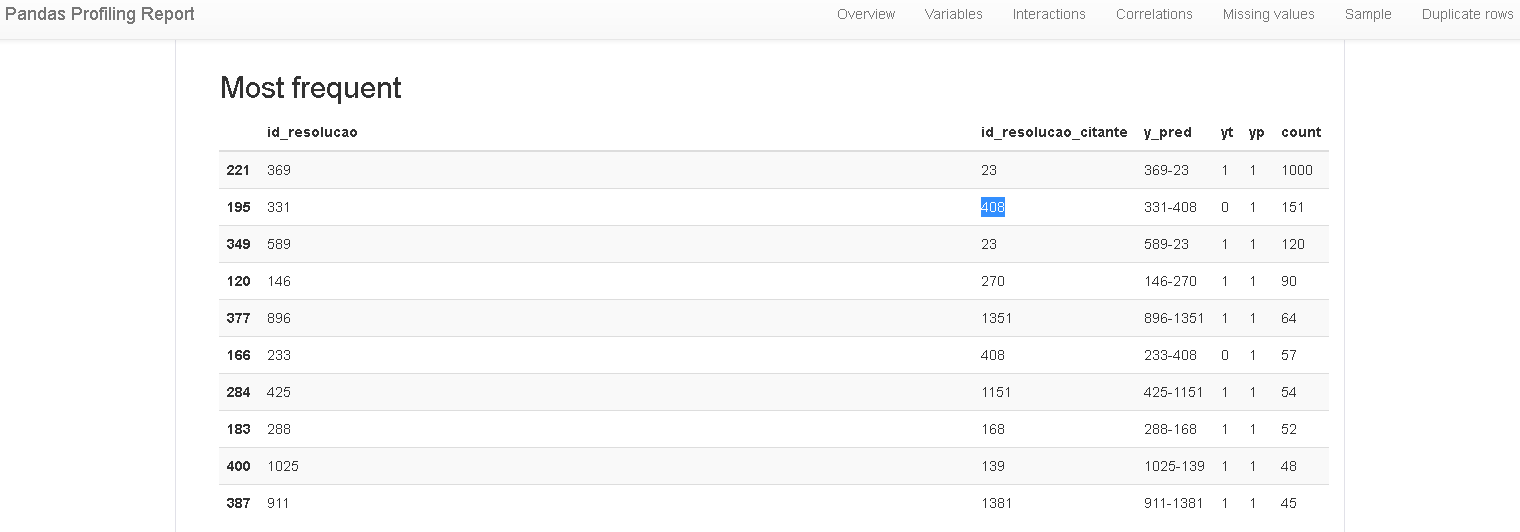

### Ponderações:
- A imagem acima é resultado do relatório em `/resolucoes-similaridade/estat_resultado.html` gerado pelo `pandas_profiling`
- São identificados casos de `false/positive` com quantidade de ocorrências significativa
    - Destaque para o par id_resolucao-id_resolucao_citante `331-408` com `151` ocorrências
- Não foram identificados casos de `true/negative` nem de `false/negative`

In [31]:
resultado[resultado['y_true'].isna()]

,id_resolucao,id_resolucao_citante,y_true,y_pred
7209,94,4,NaN,94-4
7210,94,4,NaN,94-4
7211,94,4,NaN,94-4
7212,94,4,NaN,94-4
7213,94,4,NaN,94-4
...,...,...,...,...
9172,1382,1382,NaN,1382-1382
9173,1382,1382,NaN,1382-1382
9174,1382,1382,NaN,1382-1382
9175,1382,1382,NaN,1382-1382


In [32]:
resultado = resultado.fillna(0)
resultado[resultado['y_true'].isna()]

,id_resolucao,id_resolucao_citante,y_true,y_pred


In [33]:
resultado['yt'] = 0
resultado['yp'] = 0
for i in range(len(resultado)):
    if resultado.iloc[i].y_true == resultado.iloc[i].y_pred:
        resultado.loc[i,'yt'] = 1
        resultado.loc[i,'yp'] = 1
    else:
        resultado.loc[i,'yt'] = 0
        resultado.loc[i,'yp'] = 1

resultado

,id_resolucao,id_resolucao_citante,y_true,y_pred,yt,yp
0,10,116,10-116,10-116,1,1
1,10,116,10-116,10-116,1,1
2,10,116,10-116,10-116,1,1
3,10,116,10-116,10-116,1,1
4,10,116,10-116,10-116,1,1
...,...,...,...,...,...,...
9172,1382,1382,0,1382-1382,0,1
9173,1382,1382,0,1382-1382,0,1
9174,1382,1382,0,1382-1382,0,1
9175,1382,1382,0,1382-1382,0,1


In [34]:
print('y_true==0 -> {} y_true==1 -> {}'.format(resultado[resultado['y_true']=='0'].shape, resultado[resultado['y_true']!='0'].shape))
print('y_pred==0 -> {}   y_pred==1 -> {}'.format(resultado[resultado['y_pred']=='0'].shape ,resultado[resultado['y_pred']!='0'].shape))

y_true==0 -> (0, 6) y_true==1 -> (9177, 6)
y_pred==0 -> (0, 6)   y_pred==1 -> (9177, 6)


In [35]:
from sklearn.metrics import accuracy_score
print('Acurácia: {:.2f}%'.format(accuracy_score(resultado.yt, resultado.yp)*100))

Acurácia: 78.56%


In [36]:
from sklearn.metrics import classification_report
print(classification_report(resultado.yt, resultado.yp, target_names=['y_true','y_pred']))

              precision    recall  f1-score   support

      y_true       0.00      0.00      0.00      1968
      y_pred       0.79      1.00      0.88      7209

    accuracy                           0.79      9177
   macro avg       0.39      0.50      0.44      9177
weighted avg       0.62      0.79      0.69      9177



### Identificar o id_resolucao_citante via banco de dados

In [ ]:
import os
import sys
#import numpy
import logging
import configparser
import mysql.connector
config = configparser.RawConfigParser(allow_no_value=True)
config.read(os.path.dirname(os.path.abspath(__file__))+'/config.ini', encoding='utf8')
banco = dict(config._sections)

for k in banco:
    banco[k] = dict(config._defaults, **banco[k])
    banco[k].pop('__name__', None)

caminho_qlik_sense = 'C:/Users/sandi.engesoftware/Documents/workspace/resolucoes-similaridade/mnt/resolucoes-repo/'
caminho_qlik_sense = '/mnt/resolucoes-repo/'
logging.basicConfig(filename=caminho_qlik_sense + 'resolucoes.log', filemode='w',
                    format='[%(asctime)s]: %(name)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)

legislacaodb = []

try:
    legislacaodb = mysql.connector.connect(
        host=banco['banco']['host'],
        port=banco['banco']['port'],
        user=banco['banco']['user'],
        passwd=banco['banco']['passwd']
    )
except Exception as e:
    logging.error(e)
    raise Exception('deu erro')

# o SQL abaixo foi testado e está em conformidade com as necessidades deste programa
query = """
    select
        distinct substring(alias, length(substring_index(alias, '-', 1))+2, length(alias)) as nro_res,
        ctx.id, ctx.alias, ctx.title
    from prod_legislacao.bno4z_content ctx
    where 
            lower(ctx.title) like 'resolu%'
        and ctx.language <> 'en-US' 
        and ctx.language <> 'es-ES' 
        and state=1
    order by nro_res
    """

In [ ]:
a='conjunta-1'
b='conjunta-2'
c='funttel-93'
d='funttel-94'
e='funttel-95'
f='funttel-97'
g='n-330-de-05-de-fevereiro-de-2003,278,"Resolução nº 330, de 05 de fevereiro de 2003 (REVOGADA)"'
h='Resolução nº 005, de 15 de janeiro de 1998.,§'
i='Resolução nº 069, de 23 de novembro de 1998'
print(find_nro_resolucao(a))
print(find_nro_resolucao(b))
print(find_nro_resolucao(c))
print(find_nro_resolucao(d))
print(find_nro_resolucao(e))
print(find_nro_resolucao(f))
print(find_nro_resolucao(g))
print('')
print(find_id_resolucao('conjunta-1,84,"Resolução Conjunta nº 1, de 24 de novembro de 1999 (Aneel, Anatel e ANP)"'))
print(find_id_resolucao('"Resolução Conjunta nº 1, de 24 de novembro de 1999 (Aneel, Anatel e ANP)"'))
print(find_id_resolucao('Resolução nº 24, de 22 de setembro de 1966'))
print('')
print(find_nro_resolucao(h))
print(find_nro_resolucao(i))
print(find_id_resolucao(h))
print(find_id_resolucao(i))
print('')
print(clean_citacao('Resolução nº 491, de 12 de fevereiro de 2008.,CAPÍTULO'))

In [ ]:
""" citacoes_iguais = 0

# citações sem duplicidade em Resolucoes.py
res_citacoes = resolucoes_py[['id_resolucao','id_resolucao_citante']].drop_duplicates()
# citações sem duplicidade em citacoes.ipynb
cit_citacoes = citacoes_ipynb[['id_resolucao','id_resolucao_citante']].drop_duplicates()

#lista_ypred = str(cit_citacoes['id_resolucao']) +'_'+ str(cit_citacoes['id_resolucao_citante'])
#lista_ytrue = str(res_citacoes['id_resolucao_citante']) +'_'+ str(res_citacoes['id_resolucao_citante'])

# usando id_resolucao_citante, encontra citações iguais em Resolucoes.py e citacoes.ipynb
for y_pred_idx in range(len(cit_citacoes.id_resolucao)):
    for y_true_idx in range(len(res_citacoes.id_resolucao)):
        #if int(y_true) == int(y_pred):
        if (cit_citacoes.loc[y_pred_idx].id_resolucao == res_citacoes.loc[y_true_idx].id_resolucao) & (cit_citacoes.loc[y_pred_idx].id_resolucao_citante == res_citacoes.loc[y_true_idx].id_resolucao_citante):
            citacoes_iguais += 1

#total sem duplicidade em citacoes.ipynb
qtd_cit_citacoes = citacoes_ipynb.id_resolucao.drop_duplicates().count()
#total sem duplicidade em Resolucoes.py
qtd_res_citacoes = resolucoes_py.id_resolucao.drop_duplicates().count() 

print('Qtd citações em Resolucoes.py:  ', qtd_res_citacoes)
print('Qtd citações em citacoes.ipynb: ', qtd_cit_citacoes)
print('Citações que existentem em Resolucoes.py e citacoes.ipynb:', citacoes_iguais)
print('- O citacoes.ipynb tem', qtd_cit_citacoes - qtd_res_citacoes, 'citações a mais que o Resolucoes.py')

print('Acurácia: %2.2f' %(citacoes_iguais / ((qtd_cit_citacoes - qtd_res_citacoes) + citacoes_iguais) * 100)) """